# Beer Brand Clustering Analysis


## 1. Introduction & Business Objectives

This analysis performs customer segmentation on beer brands based on their nutritional and pricing characteristics. The primary objectives are:

- **Market Segmentation**: Group beer brands into distinct segments based on product attributes
- **Product Positioning**: Understand how different brands position themselves in the market
- **Strategic Insights**: Identify gaps and opportunities in the beer market

**Key Business Questions:**
- What natural groupings exist among beer brands?
- Which product attributes drive market segmentation?
- How can brands optimize their positioning strategy?

## 2. Data Loading & Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import f_classif
from yellowbrick.cluster import SilhouetteVisualizer
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

## 3. Data Dictionary

| Column | Description | Unit | Business Relevance |
|--------|-------------|------|--------------------|
| **name** | Beer brand name | Text | Brand identifier |
| **calories** | Caloric content per serving | kcal | Health-conscious positioning |
| **sodium** | Sodium content | mg | Health/dietary considerations |
| **alcohol** | Alcohol by volume | % | Strength positioning |
| **cost** | Price per unit | USD | Value positioning |

## 4. Data Preparation & Transformation

In [4]:
def load_and_explore_data(file_path):
    """
    Load beer dataset and display basic information.

    Parameters:
    file_path (str): Path to the CSV file

    Returns:
    pd.DataFrame: Loaded dataset
    """
    df = pd.read_csv(file_path)

    print(f"Dataset Shape: {df.shape}")
    print(f"Missing Values: {df.isnull().sum().sum()}")
    print("\nDataset Overview:")
    print(df.describe())

    return df

In [33]:
beer_df = load_and_explore_data("beer.csv")

Dataset Shape: (19, 5)
Missing Values: 0

Dataset Overview:
         calories     sodium    alcohol       cost
count   19.000000  19.000000  19.000000  19.000000
mean   131.263158  14.947368   4.415789   0.495263
std     30.546580   6.761605   0.772631   0.148787
min     68.000000   6.000000   2.300000   0.280000
25%    107.500000   9.000000   4.200000   0.425000
50%    144.000000  15.000000   4.600000   0.430000
75%    149.500000  19.000000   4.900000   0.485000
max    175.000000  27.000000   5.500000   0.790000


In [35]:
beer_df

,name,calories,sodium,alcohol,cost
0,Budweiser,144,15,4.7,0.43
1,Schlitz,151,19,4.9,0.43
2,Kronenbourg,170,7,5.2,0.73
3,Heineken,152,11,5.0,0.77
4,Old_Milwaukee,145,23,4.6,0.28
5,Augsberger,175,24,5.5,0.40
6,Srohs_Bohemian_Style,149,27,4.7,0.42
7,Miller_Lite,99,10,4.3,0.43
8,Budweiser_Light,113,8,3.7,0.40
9,Coors,140,18,4.6,0.44


In [6]:
def prepare_clustering_data(df, features):
    """
    Scale features for clustering analysis.

    Parameters:
    df (pd.DataFrame): Input dataset
    features (list): List of feature columns to scale

    Returns:
    tuple: (scaled_data, scaler_object)
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

    print("Feature scaling completed using Min-Max normalization")
    print(f"Scaled data shape: {scaled_df.shape}")

    return scaled_df, scaler

In [7]:
clustering_features = ['calories', 'sodium', 'alcohol', 'cost']
scaled_beer_df, scaler = prepare_clustering_data(beer_df, clustering_features)

Feature scaling completed using Min-Max normalization
Scaled data shape: (19, 4)


## 5. Exploratory Data Analysis

In [8]:
def create_exploratory_plots(df):
    """
    Create exploratory scatter plots to understand data relationships.

    Parameters:
    df (pd.DataFrame): Input dataset
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Alcohol vs Calories
    sns.scatterplot(data=df, x='alcohol', y='calories', ax=axes[0], s=80, alpha=0.7)
    axes[0].set_title('Beer Positioning: Alcohol Content vs Caloric Value',
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Alcohol Content (%)', fontsize=12)
    axes[0].set_ylabel('Calories per Serving (kcal)', fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Alcohol vs Cost
    sns.scatterplot(data=df, x='alcohol', y='cost', ax=axes[1], s=80, alpha=0.7)
    axes[1].set_title('Market Positioning: Alcohol Content vs Price Point',
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Alcohol Content (%)', fontsize=12)
    axes[1].set_ylabel('Price per Unit (USD)', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

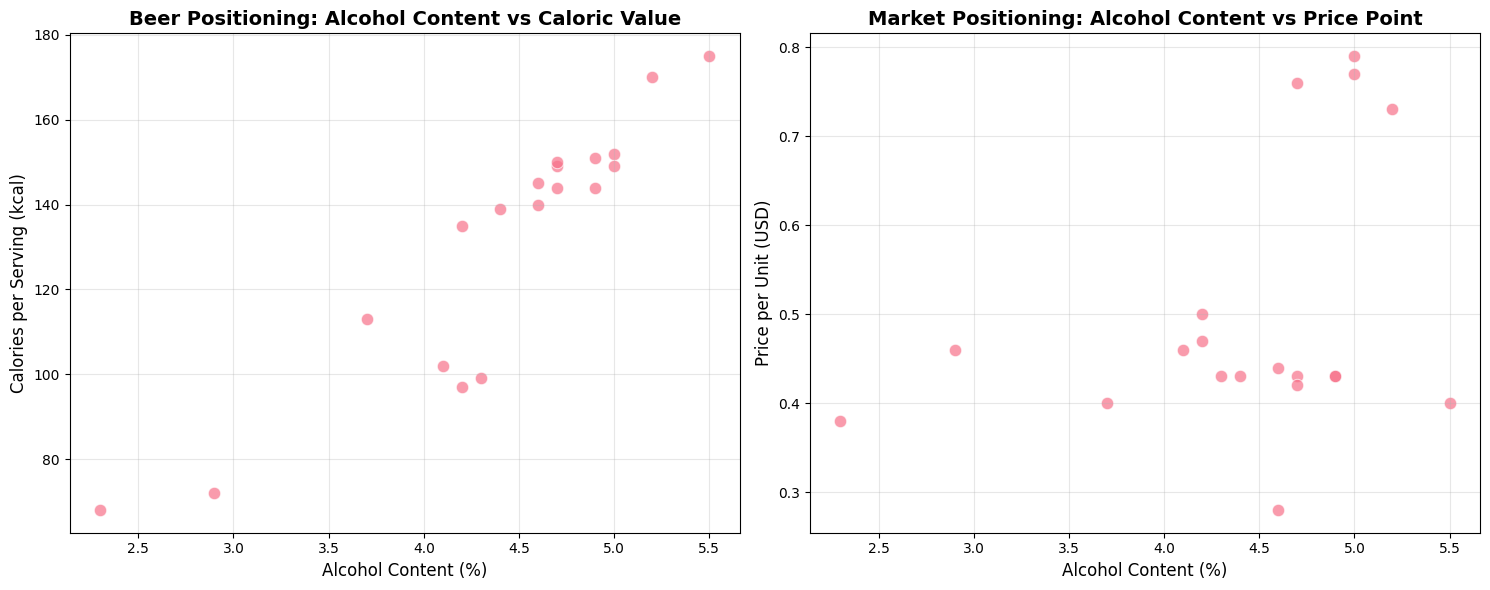

In [9]:
create_exploratory_plots(beer_df)

## 6. Clustering Analysis

### Optimal Cluster Selection using Elbow Method

In [36]:
def find_optimal_clusters(scaled_data, max_clusters=10):
    """
    Use elbow method to find optimal number of clusters.

    Parameters:
    scaled_data (pd.DataFrame): Scaled feature data
    max_clusters (int): Maximum number of clusters to test

    Returns:
    dict: Dictionary with cluster range and corresponding inertia values
    """
    cluster_range = range(1, max_clusters + 1)
    inertia_values = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k,
                        random_state=42,
                        n_init=10)

        kmeans.fit(scaled_data)
        inertia_values.append(kmeans.inertia_)

    # Create elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range,
             inertia_values,
             marker='o',
             linewidth=2,
             markersize=8,
             color = 'red')

    plt.title('Elbow Method for Optimal Cluster Selection',
              fontsize=16,
              fontweight='bold')

    plt.xlabel('Number of Clusters (k)',
               fontsize=12)

    plt.ylabel('Within-Cluster Sum of Squares (WCSS)',
               fontsize=12)

    plt.grid(True, alpha=0.3)
    plt.xticks(cluster_range)

    # Annotate potential elbow points
    for i, txt in enumerate(inertia_values):
        plt.annotate(f'{txt:.2f}', (cluster_range[i], inertia_values[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()

    return {'cluster_range': list(cluster_range), 'inertia_values': inertia_values}

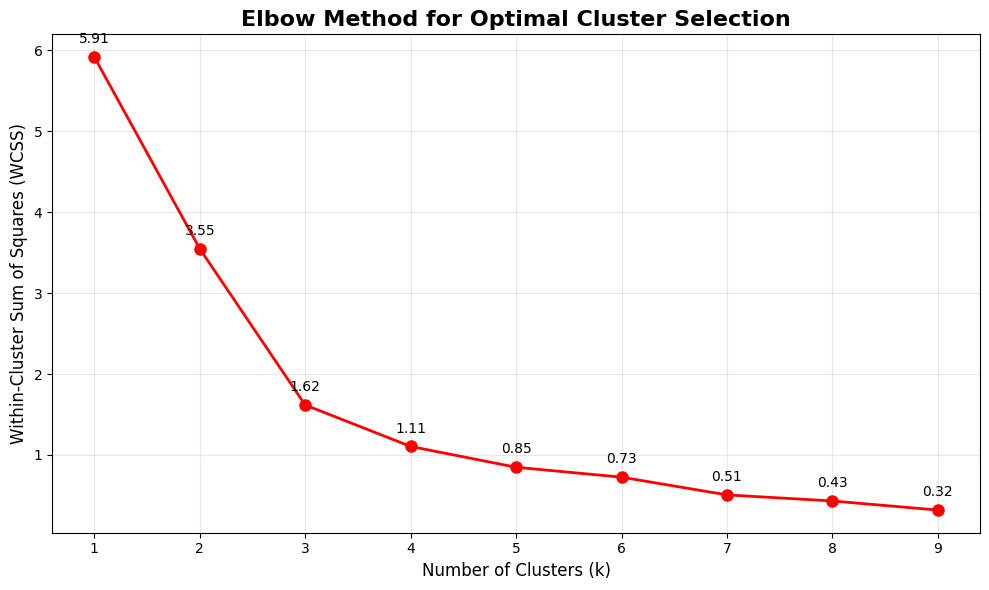

In [37]:
elbow_results = find_optimal_clusters(scaled_beer_df, max_clusters=9)

## 7. Model Evaluation

### Silhouette Analysis

In [38]:
def visualize_silhouette_analysis(scaled_data, k_values=[2, 3, 4, 5]):
    """
    Create silhouette visualizations for different cluster numbers using Yellowbrick.

    Parameters:
    scaled_data (pd.DataFrame): Scaled feature data
    k_values (list): List of k values to evaluate

    Returns:
    pd.DataFrame: Silhouette scores for each k value
    """
    n_clusters = len(k_values)
    n_cols = 2
    n_rows = (n_clusters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_clusters > 1 else [axes]

    silhouette_results = []

    print("Silhouette Analysis Results:")
    print("-" * 40)

    for i, k in enumerate(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

        # Create silhouette visualizer
        visualizer = SilhouetteVisualizer(
            kmeans,
            colors='yellowbrick',
            ax=axes[i]
        )

        # Fit the visualizer and the model
        visualizer.fit(scaled_data)

        # Get silhouette score
        sil_score = visualizer.silhouette_score_
        silhouette_results.append({
            'n_clusters': k,
            'silhouette_score': sil_score
        })

        # Customize the plot
        axes[i].set_title(f'Silhouette Analysis (k={k}, score={sil_score:.3f})',
                         fontsize=12, fontweight='bold')

        print(f"k = {k:2d} | Silhouette Score: {sil_score:.3f}")

    # Hide empty subplots
    for j in range(n_clusters, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(silhouette_results)


def calculate_calinski_harabasz_scores(scaled_data, k_values=[2, 3, 4, 5]):
    """
    Calculate Calinski-Harabasz scores for different cluster numbers.

    Parameters:
    scaled_data (pd.DataFrame): Scaled feature data
    k_values (list): List of k values to evaluate

    Returns:
    pd.DataFrame: Calinski-Harabasz scores for each k value
    """
    ch_results = []

    print("\nCalinski-Harabasz Index Results:")
    print("-" * 40)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_data)

        ch_score = calinski_harabasz_score(scaled_data, labels)
        ch_results.append({
            'n_clusters': k,
            'calinski_harabasz_score': ch_score,
            'inertia': kmeans.inertia_
        })

        print(f"k = {k:2d} | Calinski-Harabasz Score: {ch_score:.2f}")

    # Create visualization
    ch_df = pd.DataFrame(ch_results)

    plt.figure(figsize=(10, 6))
    plt.plot(ch_df['n_clusters'], ch_df['calinski_harabasz_score'],
             marker='o', linewidth=2, markersize=8, color='darkgreen')
    plt.title('Calinski-Harabasz Index by Number of Clusters',
              fontsize=16, fontweight='bold')
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Calinski-Harabasz Index', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)

    # Annotate points
    for i, row in ch_df.iterrows():
        plt.annotate(f'{row["calinski_harabasz_score"]:.1f}',
                    (row['n_clusters'], row['calinski_harabasz_score']),
                    textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()

    return ch_df

Silhouette Analysis Results:
----------------------------------------
k =  2 | Silhouette Score: 0.352
k =  3 | Silhouette Score: 0.497
k =  4 | Silhouette Score: 0.463
k =  5 | Silhouette Score: 0.383


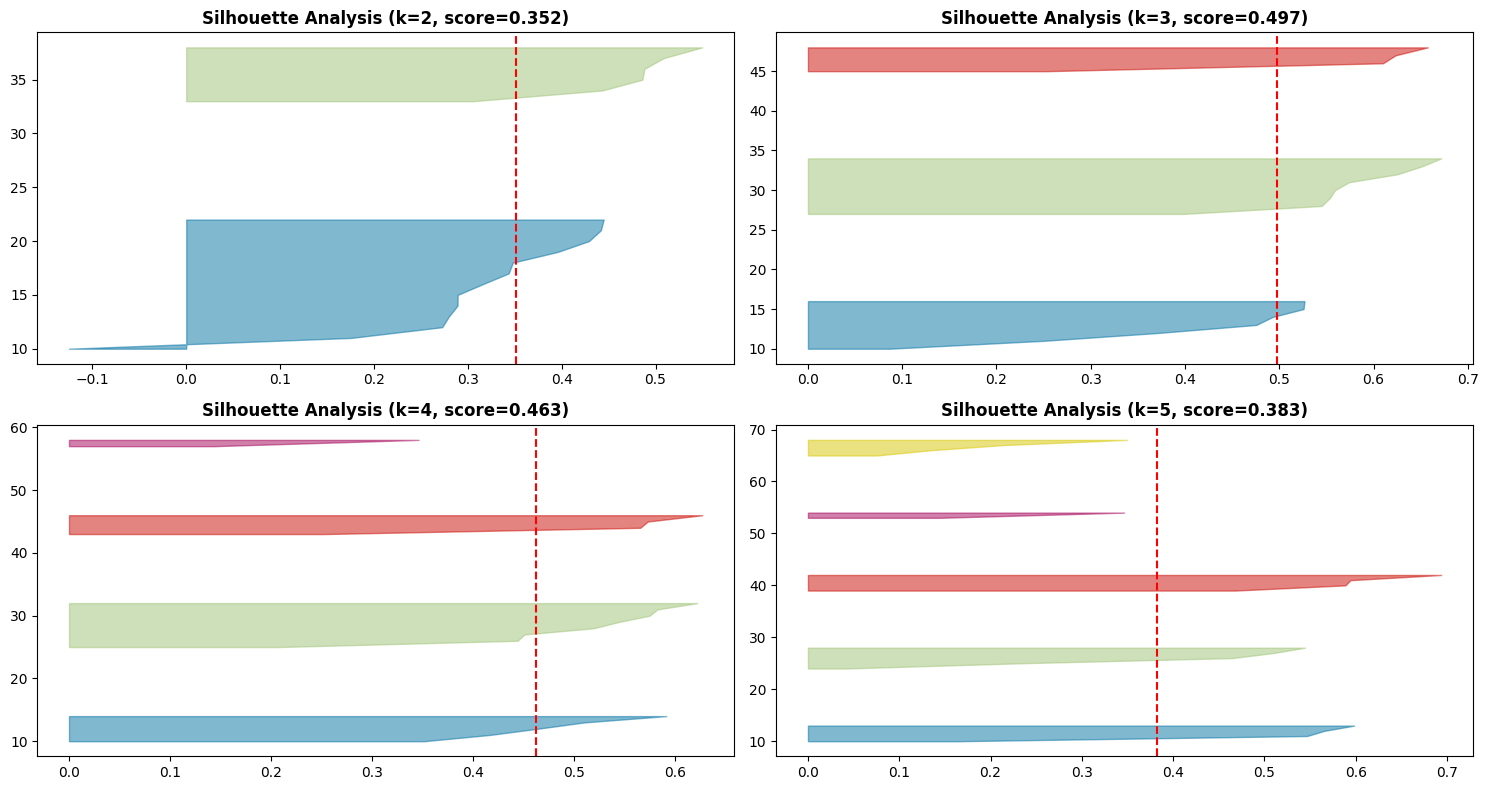

In [39]:
# Perform silhouette analysis with visualizations
silhouette_results = visualize_silhouette_analysis(scaled_beer_df)


Calinski-Harabasz Index Results:
----------------------------------------
k =  2 | Calinski-Harabasz Score: 11.35
k =  3 | Calinski-Harabasz Score: 21.26
k =  4 | Calinski-Harabasz Score: 21.74
k =  5 | Calinski-Harabasz Score: 20.90


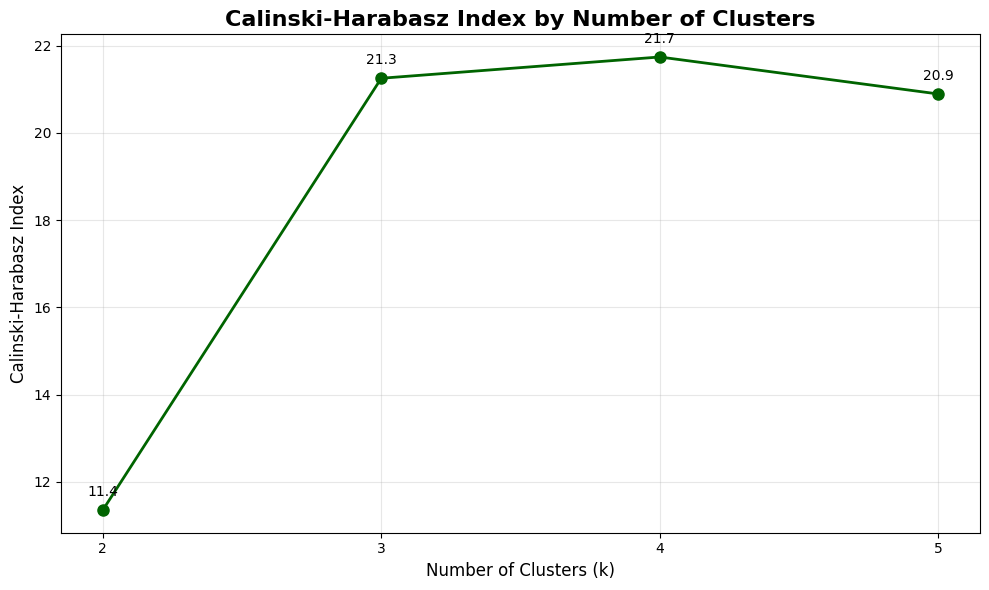


Combined Performance Results:


,n_clusters,silhouette_score,calinski_harabasz_score,inertia
0,2,0.351644,11.351436,3.546397
1,3,0.497466,21.255219,1.617335
2,4,0.462726,21.743108,1.105787
3,5,0.382888,20.895053,0.848555


In [40]:
# Calculate Calinski-Harabasz scores
ch_results = calculate_calinski_harabasz_scores(scaled_beer_df)

# Combine results
performance_results = pd.merge(silhouette_results, ch_results, on='n_clusters')
print("\nCombined Performance Results:")
performance_results

### Final Model Selection and Training

In [41]:
def train_final_model(scaled_data, n_clusters):
    """
    Train the final clustering model with specified number of clusters.

    Parameters:
    scaled_data (pd.DataFrame): Scaled feature data
    n_clusters (int): Number of clusters

    Returns:
    KMeans: Trained clustering model
    """
    final_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = final_model.fit_predict(scaled_data)

    print(f"Final model trained with {n_clusters} clusters")
    print(f"Cluster distribution: {np.bincount(cluster_labels)}")

    return final_model, cluster_labels

In [42]:
optimal_k = 5
final_model, cluster_labels = train_final_model(scaled_beer_df, optimal_k)
beer_df['cluster_id'] = cluster_labels

Final model trained with 5 clusters
Cluster distribution: [4 5 4 2 4]


## 8. Cluster Profiling

### Cluster Characteristics Analysis

In [43]:
def analyze_cluster_profiles(df, cluster_col='cluster_id', features=None):
    """
    Create detailed profiles for each cluster.

    Parameters:
    df (pd.DataFrame): Dataset with cluster assignments
    cluster_col (str): Name of cluster column
    features (list): List of features to analyze

    Returns:
    pd.DataFrame: Cluster profiles
    """
    if features is None:
        features = ['calories', 'sodium', 'alcohol', 'cost']

    cluster_profiles = df.groupby(cluster_col)[features].agg(['mean', 'std', 'count']).round(2)

    print("Cluster Profiles Summary:")
    print("=" * 80)

    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} brands):")
        print("-" * 40)

        for feature in features:
            mean_val = cluster_data[feature].mean()
            print(f"{feature.capitalize():12}: {mean_val:.2f} (avg)")

        print(f"Brands: {', '.join(cluster_data['name'].tolist())}")

    return cluster_profiles

In [44]:
cluster_profiles = analyze_cluster_profiles(beer_df)

Cluster Profiles Summary:

Cluster 0 (4 brands):
----------------------------------------
Calories    : 155.25 (avg)
Sodium      : 10.75 (avg)
Alcohol     : 4.97 (avg)
Cost        : 0.76 (avg)
Brands: Kronenbourg, Heineken, Becks, Kirin

Cluster 1 (5 brands):
----------------------------------------
Calories    : 109.20 (avg)
Sodium      : 10.20 (avg)
Alcohol     : 4.10 (avg)
Cost        : 0.45 (avg)
Brands: Miller_Lite, Budweiser_Light, Coors_Light, Michelob_Light, Schlitz_Light

Cluster 2 (4 brands):
----------------------------------------
Calories    : 143.50 (avg)
Sodium      : 17.75 (avg)
Alcohol     : 4.65 (avg)
Cost        : 0.43 (avg)
Brands: Budweiser, Schlitz, Coors, Hamms

Cluster 3 (2 brands):
----------------------------------------
Calories    : 70.00 (avg)
Sodium      : 10.50 (avg)
Alcohol     : 2.60 (avg)
Cost        : 0.42 (avg)
Brands: Pabst_Extra_Light, Olympia_Goled_Light

Cluster 4 (4 brands):
----------------------------------------
Calories    : 153.25 (avg)
Sod

### Feature Importance Analysis

In [45]:
def analyze_feature_importance(scaled_data, cluster_labels):
    """
    Analyze which features contribute most to cluster separation.

    Parameters:
    scaled_data (pd.DataFrame): Scaled feature data
    cluster_labels (array): Cluster assignments

    Returns:
    pd.Series: Feature importance scores
    """
    f_scores, p_values = f_classif(scaled_data, cluster_labels)
    importance_df = pd.DataFrame({
        'feature': scaled_data.columns,
        'f_score': f_scores,
        'p_value': p_values
    }).sort_values('f_score', ascending=False)

    # Create importance plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(importance_df['feature'], importance_df['f_score'],
                   color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title('Feature Importance for Cluster Separation',
              fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('F-Score', fontsize=12)
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, score in zip(bars, importance_df['f_score']):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    return importance_df

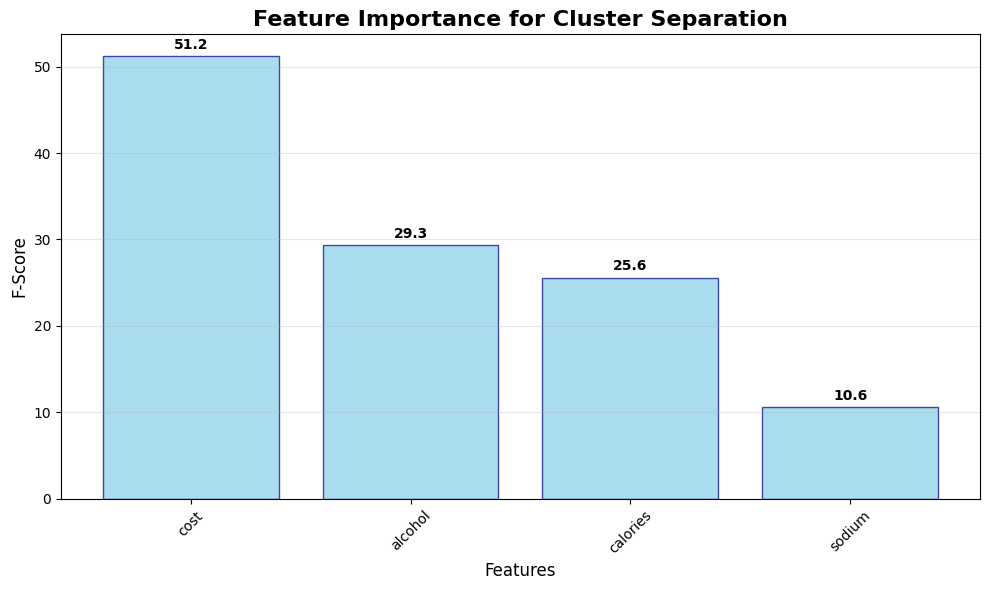


Feature Importance Ranking:
    feature    f_score       p_value
3      cost  51.181745  3.323832e-08
2   alcohol  29.345783  1.131623e-06
0  calories  25.582716  2.616962e-06
1    sodium  10.633051  3.579712e-04


In [46]:
feature_importance = analyze_feature_importance(scaled_beer_df, cluster_labels)
print("\nFeature Importance Ranking:")
print(feature_importance)

### Cluster Visualization

In [47]:
def create_cluster_distribution_plots(df, features, cluster_col='cluster_id'):
    """
    Create distribution plots for each feature by cluster.

    Parameters:
    df (pd.DataFrame): Dataset with cluster assignments
    features (list): List of features to plot
    cluster_col (str): Name of cluster column
    """
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, feature in enumerate(features):
        #sns.kdeplot(data=df, x=feature, hue=cluster_col, ax=axes[i],
        #           fill=True, alpha=0.6, linewidth=2)
        sns.boxplot(data=df, y=feature, x=cluster_col, ax=axes[i])
        axes[i].set_title(f'{feature.capitalize()} Distribution by Cluster',
                         fontsize=14, fontweight='bold')
        axes[i].set_xlabel(f'{feature.capitalize()}', fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(title='Cluster', title_fontsize=10)

    # Hide empty subplots
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

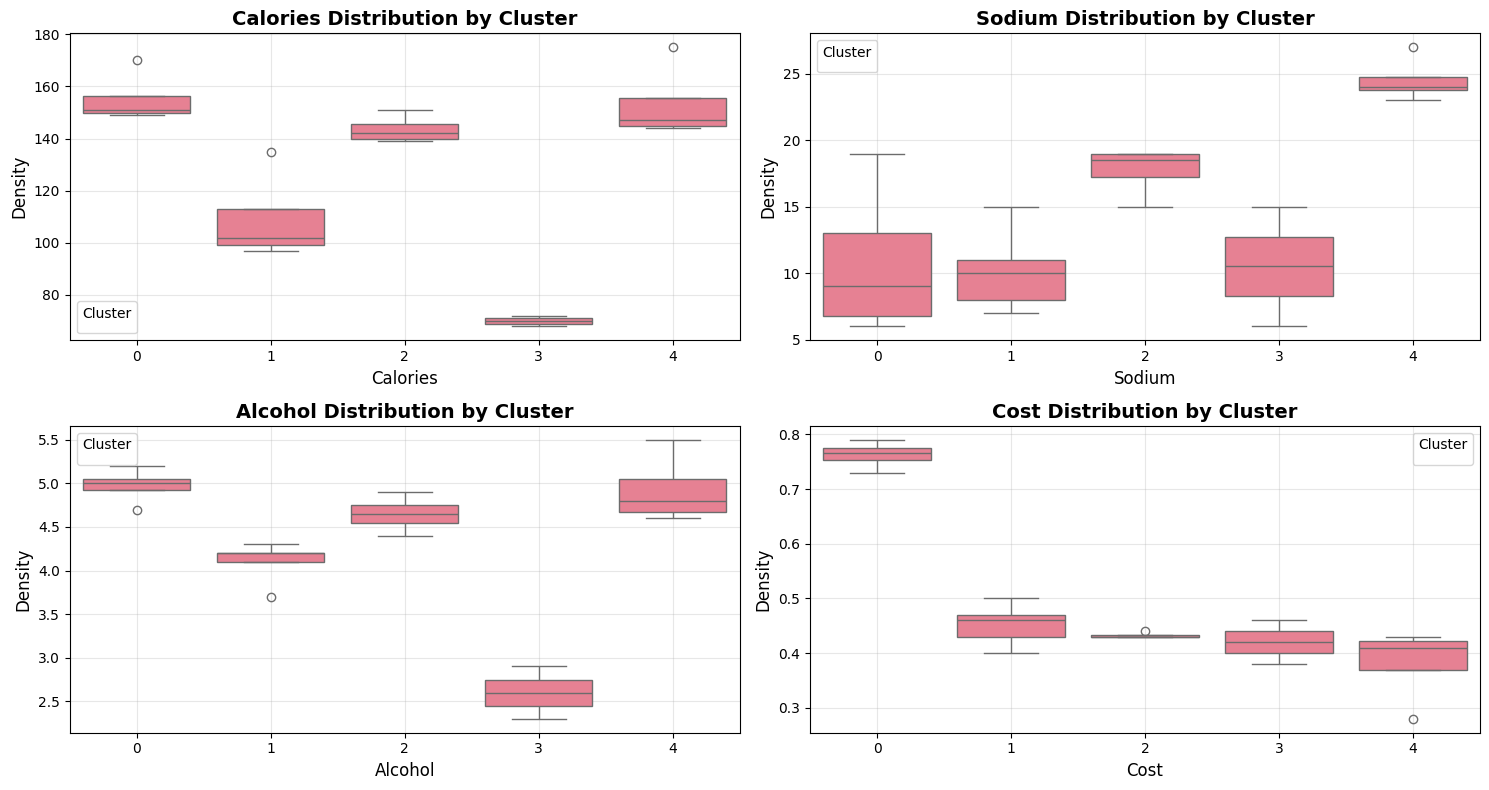

In [48]:
create_cluster_distribution_plots(beer_df, clustering_features)